In [80]:
import pandas as pd
import scanpy as sc
import numpy as np
import gzip
import re
import harmonypy as hm

In [38]:
def load_gse120575_expression_simple(path):
    """
    Safely load GSE120575 TPM matrix.
    - Header: first field is empty, then cell IDs.
    - Each data row: gene name + one value per cell.
    - Extra columns at the end are dropped.
    - Short rows are padded with NaN.
    """
    with gzip.open(path, "rt", encoding="latin1", errors="replace") as f:
        header = f.readline().rstrip("\n").split("\t")
        # header[0] is empty, rest are cell IDs
        cell_ids = header[1:]
        n_cells = len(cell_ids)

        genes = []
        rows = []

        for raw_line in f:
            line = raw_line.rstrip("\n")
            if not line.strip():
                # skip completely empty lines
                continue

            parts = line.split("\t")
            if len(parts) < 2:
                # no gene or no values → skip
                continue

            gene = parts[0].strip()
            if gene == "":
                continue

            values = parts[1:]

            # Fix length to exactly n_cells
            if len(values) < n_cells:
                values = values + ["nan"] * (n_cells - len(values))
            elif len(values) > n_cells:
                values = values[:n_cells]

            genes.append(gene)
            rows.append(values)

    df = pd.DataFrame(rows, index=genes, columns=cell_ids)
    df = df.apply(pd.to_numeric, errors="coerce")
    return df


In [39]:
# Expression matrix
# Genes as rows, cells as columns (TPM values)
expr_path = "../data/GSE120575_Sade_Feldman_melanoma_single_cells_TPM_GEO.txt.gz"
expr = load_gse120575_expression_simple(expr_path)

In [ ]:
# Take transpose to get cells * genes
expr = expr.T
print(expr.shape)
print(expr.head())

(16291, 55737)
            TSPAN6  TNMD  DPM1  SCYL3  C1orf112  FGR  CFH  FUCA2  GCLC  NFYA  \
A10_P3_M11     0.0   0.0  0.00    0.0       0.0  0.0  0.0    0.0  0.00   0.0   
A11_P1_M11     0.0   0.0  9.24    0.0       0.0  0.0  0.0    0.0  1.01   0.0   
A11_P3_M11     0.0   0.0  0.00    0.0       0.0  0.0  0.0    0.0  0.00   0.0   
A11_P4_M11     0.0   0.0  7.99    0.0       0.0  0.0  0.0    0.0  0.00   0.0   
A12_P3_M11     0.0   0.0  0.00    0.0       0.0  0.0  0.0    0.0  0.00   0.0   

            ...  RP11-126K1.9  RP4-671G15.2  OR6R2P  RP11-225H22.7  \
A10_P3_M11  ...           0.0           0.0     0.0            0.0   
A11_P1_M11  ...           0.0           0.0     0.0            0.0   
A11_P3_M11  ...           0.0           0.0     0.0            0.0   
A11_P4_M11  ...           0.0           0.0     0.0            0.0   
A12_P3_M11  ...           0.0           0.0     0.0            0.0   

            RP11-731C17.2  RP4-621B10.8  RP11-114I8.4  RP11-180C16.1  \
A10_P3_M11 

In [ ]:
# Not required; keeping just in case expr got corrupted somewhere; I don't want to load again :(
expr_or_copy = expr.copy()

In [44]:
def load_gse120575_metadata(path):
    """
    Load sample-level metadata from GSE120575_patient_ID_single_cells.txt.gz.
    Automatically skips GEO template header.
    Returns a clean DataFrame with CellID, PatientID, Timepoint, Response, Therapy.
    """
    rows = []

    with gzip.open(path, "rt", encoding="latin1", errors="replace") as f:
        for line in f:
            line = line.strip()
            if re.match(r"^Sample\s+\d+", line):
                parts = line.split("\t")
                rows.append(parts)

    # Build dataframe
    df = pd.DataFrame(rows)

    # Assign real column names manually (from the GEO paper)
    df.columns = [
        "Sample_name",
        "CellID",
        "Source_name",
        "Organism",
        "PatientID_raw",
        "Response",
        "Therapy"
    ]

    # Clean up PatientID_raw of format Pre_P1 → Timepoint + PatientID
    df["Timepoint"] = df["PatientID_raw"].str.split("_").str[0]
    df["PatientID"] = df["PatientID_raw"].str.split("_").str[1]

    # Keep the useful columns only
    df = df[["CellID", "PatientID", "Timepoint", "Response", "Therapy"]]

    return df


In [ ]:
# Load metadata
metadata_path = "../data/GSE120575_patient_ID_single_cells.txt.gz"
meta = load_gse120575_metadata(metadata_path)

In [46]:
print(meta.head())

       CellID PatientID Timepoint   Response     Therapy
0  A10_P3_M11        P1       Pre  Responder  anti-CTLA4
1  A11_P1_M11        P1       Pre  Responder  anti-CTLA4
2  A11_P3_M11        P1       Pre  Responder  anti-CTLA4
3  A11_P4_M11        P1       Pre  Responder  anti-CTLA4
4  A12_P3_M11        P1       Pre  Responder  anti-CTLA4


In [47]:
print("Expression shape (cells x genes):", expr.shape)
print("Metadata shape (cells x meta-cols):", meta.shape)

Expression shape (cells x genes): (16291, 55737)
Metadata shape (cells x meta-cols): (16291, 5)


In [49]:
meta = meta.set_index("CellID")

In [ ]:
# Just a confirmation
common_cells = expr.index.intersection(meta.index)
expr = expr.loc[common_cells]
meta = meta.loc[common_cells]

print("After align:", expr.shape, meta.shape)

After align: (16291, 55737) (16291, 4)


In [ ]:
# Copied over from Sumeet's datapeek file to view stats
# library size per cell
libs = expr.sum(axis=0)
print(libs.describe())
# What do gene labels look like?
print("Index dtype:", expr.index.dtype)
print(list(expr.index[:10]))

# Quick stats on common formats
n_ensg = sum(idx.startswith("ENSG") for idx in expr.index.astype(str))
n_mt   = sum(str(idx).upper().startswith(("MT-","MT.")) for idx in expr.index.astype(str))
print("Rows starting with ENSG:", n_ensg, "of", len(expr.index))
print("Rows looking like mitochondrial (MT-):", n_mt)


count     55737.000000
mean       4480.133344
std       13725.346153
min           0.000000
25%          22.250000
50%         115.340000
75%        1718.320000
max      267676.480000
dtype: float64
Index dtype: object
['A10_P3_M11', 'A11_P1_M11', 'A11_P3_M11', 'A11_P4_M11', 'A12_P3_M11', 'A12_P6_M11', 'A2_P1_M11', 'A2_P4_M11', 'A3_P1_M11', 'A3_P3_M11']
Rows starting with ENSG: 0 of 16291
Rows looking like mitochondrial (MT-): 0


In [ ]:
# Fill the nan values with 0s
expr_zeroed = expr.fillna(0.0)

In [ ]:
# Package meta data and expr values into anndata object
adata = sc.AnnData(expr_zeroed, obs=meta)
print(adata)

AnnData object with n_obs × n_vars = 16291 × 55737
    obs: 'PatientID', 'Timepoint', 'Response', 'Therapy'


In [ ]:
# Check how many pre cells we have
print(adata.obs["Timepoint"].value_counts())

Timepoint
Post    10363
Pre      5928
Name: count, dtype: int64


In [ ]:
# QC: removed mt filtering for now since not sure if they exist?
sc.pp.calculate_qc_metrics(
    adata, 
    # qc_vars=["mt"], 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

In [91]:
# basic filters
adata = adata[adata.obs["n_genes_by_counts"] > 200, :]
adata = adata[:, adata.var["n_cells_by_counts"] > 2]
# adata = adata[adata.obs["pct_counts_mt"] < 50, :]

print("After QC:", adata.shape)

After QC: (16291, 45884)


/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


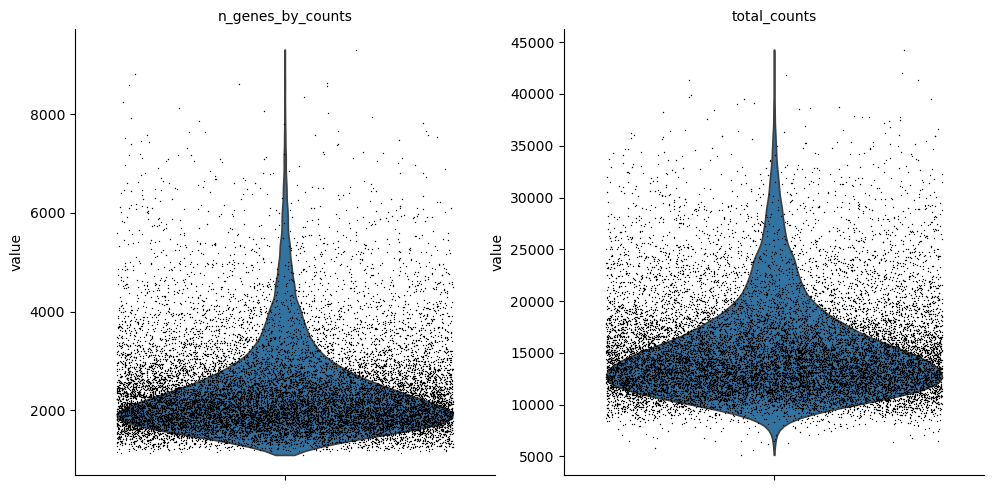

In [ ]:
# Data after filtering
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts"], jitter=0.4, multi_panel=True)

In [ ]:
# Library-size normalize
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform
sc.pp.log1p(adata)

# Keep all genes in raw: Will be needed later when predicting cell types
adata.raw = adata.copy()

# Select highly variable genes: For PCA mainly
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True)

# Scale (zero-mean / unit variance)
sc.pp.scale(adata, max_value=10)

print("After HVG selection:", adata.shape)

After HVG selection: (16291, 3000)


In [94]:
sc.tl.pca(adata, svd_solver="arpack")

In [ ]:
# Optional: Harmony on pca to correct for batch effects
ho = hm.run_harmony(
        adata.obsm["X_pca"],        # PCA embeddings
        adata.obs,                  # metadata
        "PatientID"                 # batch variable
    )
adata.obsm["X_pca_harmony"] = ho.Z_corr.T
use_rep = "X_pca_harmony"
print("Using Harmony-corrected PCA")

2025-11-20 03:09:44,398 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-20 03:09:53,299 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-20 03:09:53,371 - harmonypy - INFO - Iteration 1 of 10
2025-11-20 03:09:57,384 - harmonypy - INFO - Iteration 2 of 10
2025-11-20 03:10:03,643 - harmonypy - INFO - Iteration 3 of 10
2025-11-20 03:10:08,906 - harmonypy - INFO - Iteration 4 of 10
2025-11-20 03:10:11,549 - harmonypy - INFO - Iteration 5 of 10
2025-11-20 03:10:16,186 - harmonypy - INFO - Iteration 6 of 10
2025-11-20 03:10:20,342 - harmonypy - INFO - Iteration 7 of 10
2025-11-20 03:10:23,692 - harmonypy - INFO - Iteration 8 of 10
2025-11-20 03:10:30,416 - harmonypy - INFO - Iteration 9 of 10
2025-11-20 03:10:35,488 - harmonypy - INFO - Iteration 10 of 10
2025-11-20 03:10:40,261 - harmonypy - INFO - Stopped before convergence


Using Harmony-corrected PCA


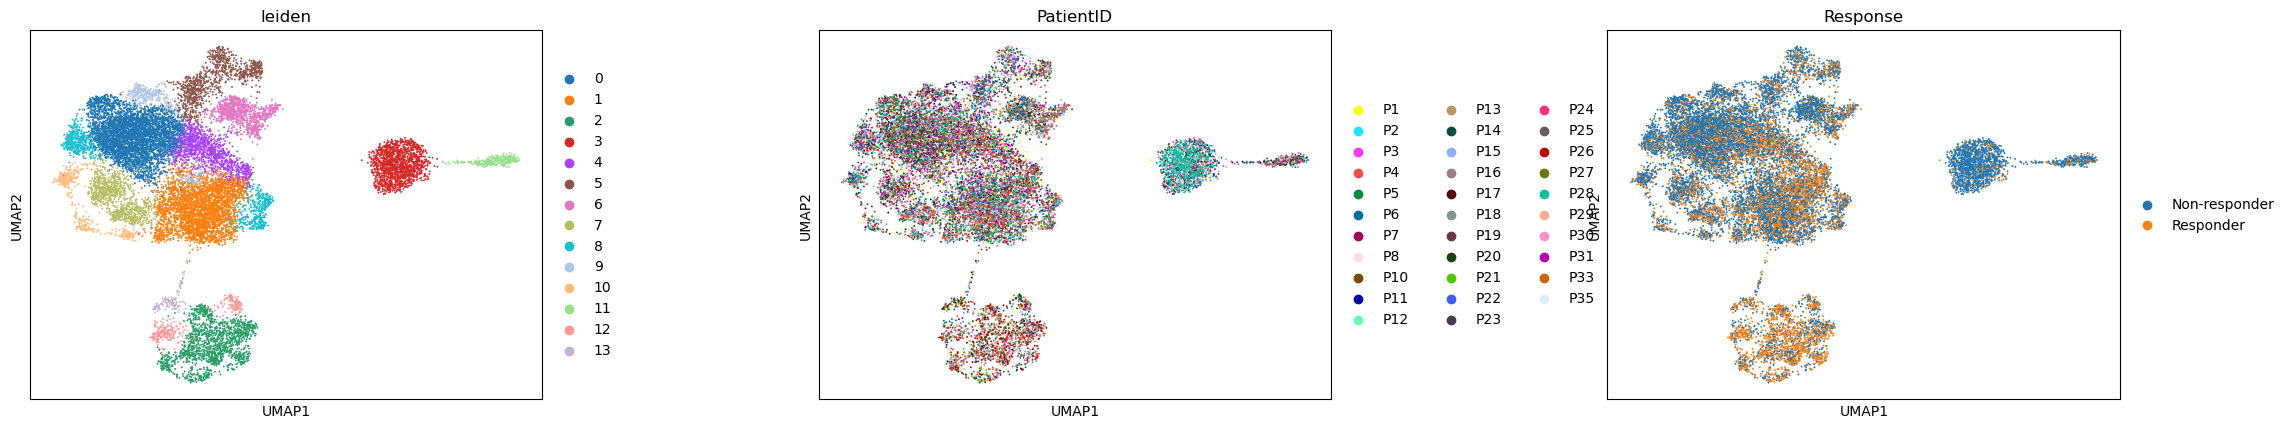

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, use_rep=use_rep)
sc.tl.umap(adata)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.6, key_added="leiden")

# quick look
sc.pl.umap(adata, color=["leiden", "PatientID", "Response"], wspace=0.4)

In [ ]:
# Get marker genes for each of the leiden clusters
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
markers_df = sc.get.rank_genes_groups_df(adata, group=None)
markers_df.to_csv("cluster_markers_leiden.csv", index=False)

markers_df.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,CD8A,59.942047,2.872018,0.0,0.0
1,0,NKG7,52.116447,2.319694,0.0,0.0
2,0,CCL5,50.905224,1.974423,0.0,0.0
3,0,CD8B,47.543491,2.700883,0.0,0.0
4,0,KLRK1,47.099640,2.128502,0.0,0.0


In [100]:
for g in ["0", "1", "2"]:
    print(f"Top markers for cluster {g}")
    display(markers_df[markers_df["group"] == g].head(10))

Top markers for cluster 0


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,CD8A,59.942047,2.872018,0.000000e+00,0.000000e+00
1,0,NKG7,52.116447,2.319694,0.000000e+00,0.000000e+00
2,0,CCL5,50.905224,1.974423,0.000000e+00,0.000000e+00
3,0,CD8B,47.543491,2.700883,0.000000e+00,0.000000e+00
4,0,KLRK1,47.099640,2.128502,0.000000e+00,0.000000e+00
5,0,PRF1,41.847466,1.909239,0.000000e+00,0.000000e+00
6,0,CCL4,41.276329,2.004248,0.000000e+00,0.000000e+00
7,0,CST7,38.618862,1.627768,0.000000e+00,0.000000e+00
8,0,GZMA,38.308735,1.849505,0.000000e+00,0.000000e+00
9,0,CCL4L1,36.820438,1.778382,8.695856e-297,3.990006e-293


Top markers for cluster 1


,group,names,scores,logfoldchanges,pvals,pvals_adj
45884,1,CD4,41.946484,2.538225,0.000000e+00,0.000000e+00
45885,1,SPOCK2,34.135998,1.482042,2.157695e-255,1.650061e-251
45886,1,IL7R,29.709410,1.760505,5.804283e-194,1.566610e-190
45887,1,CD28,29.064344,1.771343,1.013768e-185,2.584206e-182
45888,1,TNFRSF25,28.409090,2.393028,1.561505e-177,3.770953e-174
45889,1,PBXIP1,28.388948,1.286572,2.768551e-177,6.351610e-174
45890,1,TRAC,26.794559,1.059196,3.739054e-158,6.598567e-155
45891,1,MAF,26.044933,1.749401,1.535456e-149,2.516174e-146
45892,1,ICOS,25.952297,1.729225,1.712939e-148,2.710224e-145
45893,1,CD5,24.953522,1.465647,1.955422e-137,2.718866e-134


Top markers for cluster 2


,group,names,scores,logfoldchanges,pvals,pvals_adj
91768,2,CD79A,54.976135,5.652645,0.0,0.0
91769,2,MS4A1,50.408363,6.221299,0.0,0.0
91770,2,CTA-250D10.23,48.542599,5.095397,0.0,0.0
91771,2,BCL11A,48.388447,5.096289,0.0,0.0
91772,2,HLA-DRA,48.313763,2.252784,0.0,0.0
91773,2,IGHM,46.258156,5.316485,0.0,0.0
91774,2,BANK1,46.163074,6.412910,0.0,0.0
91775,2,CD74,46.044708,0.783866,0.0,0.0
91776,2,IRF8,44.209244,3.492546,0.0,0.0
91777,2,CD19,44.115730,6.543552,0.0,0.0


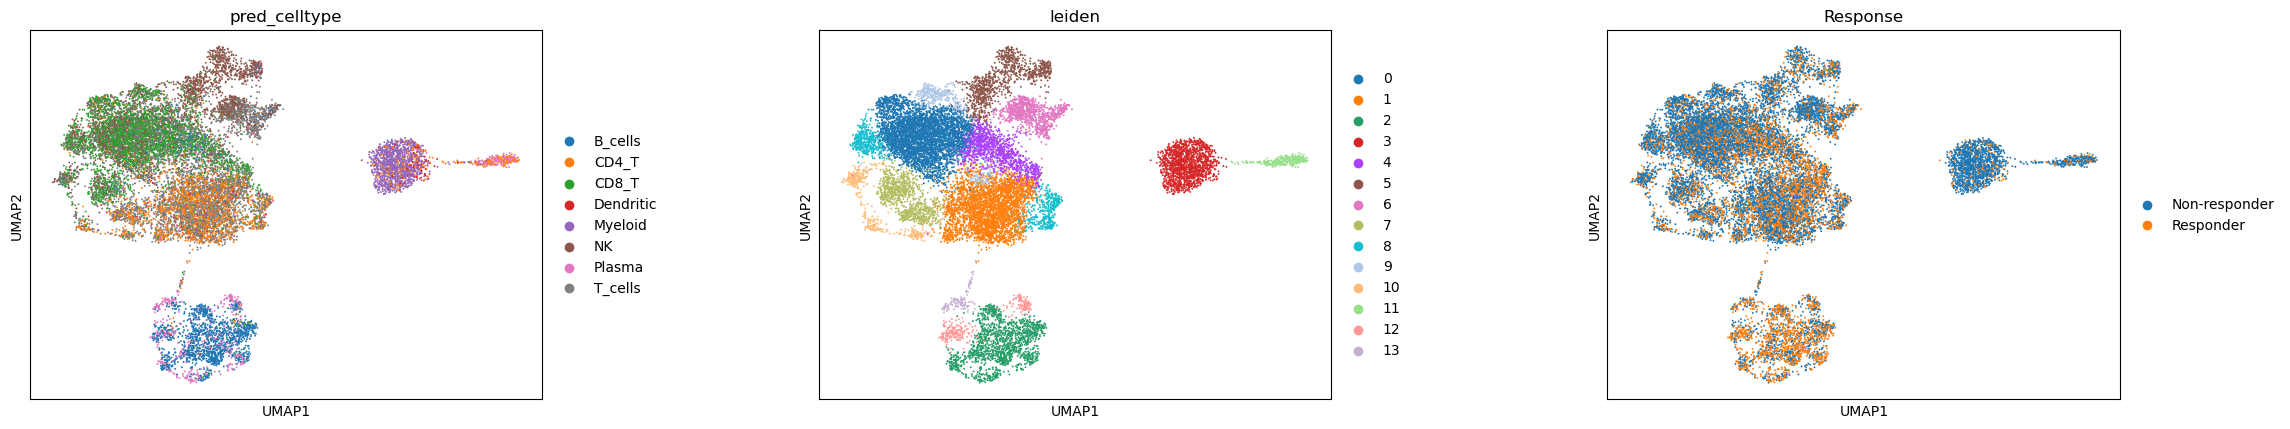

In [ ]:
# Markers for usual cell type
marker_dict = {
    "T_cells": ["CD3D", "CD3E", "CD3G"],
    "CD8_T": ["CD8A", "CD8B"],
    "CD4_T": ["CD4"],
    "B_cells": ["MS4A1"],
    "Plasma": ["MZB1", "IGKC", "IGHG1"],
    "NK": ["NKG7", "GNLY", "GZMB"],
    "Myeloid": ["LYZ", "CD68", "S100A8", "S100A9"],
    "Dendritic": ["CD1C", "CLEC9A", "FCER1A"]
}

# Score each marker set (skip genes that are absent)
for ct, genes in marker_dict.items():
    gene_list = [g for g in genes if g in adata.raw.var_names]
    if len(gene_list) == 0:
        print(f"Skipping {ct}: none of its markers are in var_names")
        adata.obs[ct] = 0.0
        continue
    sc.tl.score_genes(adata, gene_list=gene_list, score_name=ct, use_raw=True)

# pick best scoring type per cell
score_cols = list(marker_dict.keys())
adata.obs["pred_celltype"] = adata.obs[score_cols].idxmax(axis=1)

# visualize on UMAP
sc.pl.umap(adata, color=["pred_celltype", "leiden", "Response"], wspace=0.4)

In [102]:
adata.obs

,PatientID,Timepoint,Response,Therapy,n_genes_by_counts,total_counts,leiden,T_cells,CD8_T,CD4_T,B_cells,Plasma,NK,Myeloid,Dendritic,pred_celltype
A10_P3_M11,P1,Pre,Responder,anti-CTLA4,2050,14624.81,5,-0.843711,-0.843711,-0.843711,-0.163404,-0.187176,0.882426,-0.062768,-0.033180,NK
A11_P1_M11,P1,Pre,Responder,anti-CTLA4,1573,11933.60,4,0.459906,-0.891182,1.294159,2.038179,-0.215322,0.154406,-0.132787,-0.014785,B_cells
A11_P3_M11,P1,Pre,Responder,anti-CTLA4,1591,11888.79,8,0.369675,-0.802898,-0.802898,-0.162260,-0.146783,0.335024,-0.101754,-0.023565,T_cells
A11_P4_M11,P1,Pre,Responder,anti-CTLA4,2909,19693.54,1,0.577830,-1.019051,0.710130,-0.201962,0.290229,-0.448829,-0.202178,-0.026012,CD4_T
A12_P3_M11,P1,Pre,Responder,anti-CTLA4,1211,9186.06,1,1.010322,-0.589427,-0.589427,-0.132365,-0.116400,0.377833,-0.121058,-0.026326,T_cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H5_P5_M67_L001_T_enriched,P6,Post,Non-responder,anti-PD1,4355,26757.67,6,0.364462,-0.978352,-0.978352,-0.261944,0.286787,0.839737,-0.277055,-0.049882,NK
H6_P5_M67_L001_T_enriched,P6,Post,Non-responder,anti-PD1,4948,27900.06,6,0.356441,-0.907529,-0.907529,-0.487965,0.291137,0.352219,-0.276178,-0.033500,T_cells
H7_P5_M67_L001_T_enriched,P6,Post,Non-responder,anti-PD1,3208,20217.66,6,0.688081,-0.872527,-0.872527,-0.384800,0.391153,1.334229,-0.191776,-0.027943,NK
H8_P5_M67_L001_T_enriched,P6,Post,Non-responder,anti-PD1,1355,8411.66,0,0.213638,-0.607898,-0.607898,-0.205666,0.317829,2.142023,-0.168163,-0.017085,NK


In [ ]:
# Get CD8 state feature
memory_genes = ["IL7R", "CCR7", "TCF7"]
exhaustion_genes = ["PDCD1", "LAG3", "ENTPD1", "HAVCR2", "CTLA4", "TIGIT", "TOX"]

# Keep only genes that actually exist
memory_genes = [g for g in memory_genes if g in adata.raw.var_names]
exhaustion_genes = [g for g in exhaustion_genes if g in adata.raw.var_names]

print("Memory genes used:", memory_genes)
print("Exhaustion genes used:", exhaustion_genes)

# Score each set
sc.tl.score_genes(
    adata, 
    gene_list=memory_genes, 
    score_name="CD8_memory_score", 
    use_raw=True
)

sc.tl.score_genes(
    adata, 
    gene_list=exhaustion_genes, 
    score_name="CD8_exhausted_score", 
    use_raw=True
)

# Assign CD8 state
adata.obs["CD8_state"] = np.where(
    adata.obs["CD8_memory_score"] > adata.obs["CD8_exhausted_score"],
    "Memory_like",
    "Exhausted_like"
)

Memory genes used: ['IL7R', 'CCR7', 'TCF7']
Exhaustion genes used: ['PDCD1', 'LAG3', 'ENTPD1', 'HAVCR2', 'CTLA4', 'TIGIT', 'TOX']


In [104]:
adata.obs["CD8_state"].value_counts()


CD8_state
Exhausted_like    9729
Memory_like       6562
Name: count, dtype: int64

In [ ]:
# Save for future use: Adding this to the box folder: https://cmu.box.com/s/zk3zeuhr4baunkis9ig5kufau7euqggm
adata.write("../data/melanoma_scRNA_processed.h5ad", compression="gzip")